# How (and why) to use the tempering cycle script

In [1]:
%matplotlib inline
import numpy as np
import TOFPlanet
import ppbs
import observables
import ahelpers as ah

In [how_to_samplify](how_to_samplify.ipynb) we examined the chain from an MCMC run that worked well. In the trace plots we saw robust mixing between walkers and steady coverage of parameter space. The auto-correlation plots then reassured us that we can obtain a sufficiently large _independent_ sample from that single chain, by keeping every $k$-th step from each walker, with $k$ large enough to minimize correlations. We were warned that this ideal situation is not always attainable.

## A bad example

Let's look at the trace plots from a different run. 

C.shape = (160, 11000, 8)


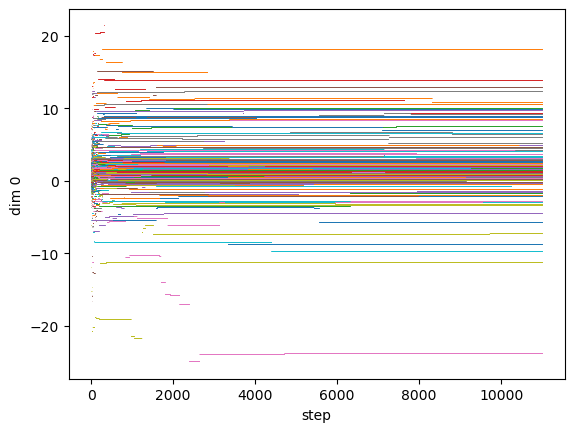

In [2]:
fname = 'J2_fail.npz'
C, L = ah.load_chain(fname)

ah.plot_traces(fname, dims=0)

The walkers don't seem to mix at all. In fact, after a burn-in phase they hardly seem to move at all.

It is not hard to understand what happened here. In this run the likelihood function was comparing model gravity with observed (actually in this case, hypothetical) gravity with very tight uncertainties. The seed positions have very low likelihood values to start with. There is some initial movement when random steps find higher likelihood positions and the walkers fall into local minima regions. Some of them may even fall into high likelihood positions. But once in a local minimum the tight constraints ensure that even the smallest random step away reduces the likelihood too much to be accepted. The walkers are trapped there.

What this means is that of this chain of over 10,000 steps we cannot hope to get more than one independent position per walker. Worse, most of these will be very low likelihood positions, that should not appear at all in a reasonable size sample.

## A different approach

As bad as it is, the chain displayed above may in fact contain a few valid models. How can we tell? Well, we have values returned by the log-likelihood function used in the driver. The walkers are stuck so let's look at what value they get stuck in:

In [3]:
L[:,-1]

array([-4.35092747e+04,  1.42405887e+01, -1.40075665e+02, -1.56748436e+04,
       -1.63126308e+04, -1.76819481e+04, -1.32153521e+03, -2.61385966e+02,
       -1.37753928e+03, -7.82363987e+02, -3.70787426e+06, -8.62995924e+04,
        1.68029993e+01, -4.58118534e+01, -2.17714862e+03, -1.39915649e+05,
       -8.86877924e+03, -4.27296956e+01, -6.02303950e+02, -9.02133502e+01,
       -3.93855433e+04,  4.68575180e+00, -4.28144906e+04, -1.62145017e+05,
       -1.11859008e+06,  2.27458823e+01, -3.81151728e+10, -9.28618378e-01,
       -1.65182050e+04,  1.73694737e+01, -1.30775016e+02, -3.84180252e+02,
       -1.99830006e+04, -4.08259517e+06,  2.20276972e+01, -3.98056897e+04,
       -8.21077554e+01, -3.13357262e+05, -6.58916064e+04, -1.16426142e+02,
       -3.54470441e+01,  1.22815645e+01, -1.55676774e+03, -9.03495245e+03,
       -3.36896513e+02,  2.67408526e+00, -1.13111917e+04, -7.93259428e+03,
       -9.65281722e+03, -1.04637274e+04,  4.99540114e+00, -7.20357091e+04,
       -4.55359604e+04, -

Okay, what do these values mean, in terms of how well the corresponding models match the observables? These are the values (in log) of the loss function (the distance between model values and target values, in sigma units) added to the log-prior of the parameter values. Let's look at the most successful walker, and the position it is stuck in.

In [4]:
best_w = np.argmax(L[:,-1])
best_x = C[best_w, -1, :]
best_l = L[best_w, -1]
print(f"{best_l=}")

best_l=24.024453580833676


Is that a good match or not? The likelihood value is the sum of the loss function (log) value, a distance in sigma units, plus a prior. So the distance is the likelihood minus the prior:

In [5]:
best_p = ppbs.ppbs_prior_uniform(best_x)
best_logloss = best_l - best_p
print(f"{best_logloss=}")

best_logloss=-0.589916412288428


So, is it a good match or not? What is the "sigma" equivalent? For a one-dimensional normal, the log-loss function is simply $-\frac{1}{2}d^2$ where $d$ is the distance in standard deviation units. So a "2-sigma" match would show a log-loss value of $-2$. The log-loss above corresponds to a distance of

In [6]:
best_dist = np.sqrt(-2*best_logloss)
print(f"{best_dist=}")

best_dist=1.086201097668777


We may decide that any walker with a best distance value less than some threshold, say, 2.5 sigmas, can be included in the sample. But our loss function is not one-dimensional. In this run I was matching the 1-bar density and $J_2$ values against observables, and the loss function included two normal-like terms. In general the ppbs driver has one term, plus one term for every J value, plus another term is rotation period is also varying. The 2.5 sigma equivalent of a chi squared distribution with two degrees of freedom is

In [7]:
ah._sig2mahal(2.5, 2)

2.9626005794635026

so we can accept the last step from every walker where the log-likelihood is greater than

In [8]:
thresh = 2.5 # choose a threshold "sigma" equivalent
dof = 2 # degrees of freedom (how many Js, plus one for rho0)
-0.5*ah._sig2mahal(thresh, dof)**2

-4.388501096718741

In the chain from the above, failed run, we have

In [9]:
np.size(ah.ppbs_winners(C,L,dof,ppbs.ppbs_prior_uniform,rotflag=True,sig=thresh))

8

parameter vectors that should result in models with acceptable match to observables, even with the tight constraints used. The script `save_ppbs_winners.py` will find the acceptable models at the end of a chain and append them to a text file.

In [10]:
%run save_ppbs_winners.py --help

usage: save_ppbs_winners.py [-h] [-s SEEDFILE] [--J-strict J_STRICT]
                            [--J-thresh J_THRESH] [-o OBSERVABLES]
                            [--fix-mass FIX_MASS] [--fix-rot FIX_ROT]
                            [--preserve-period PRESERVE_PERIOD] [--no-spin]
                            [--with-k2] [--toforder {4,7}]
                            [--toflevels TOFLEVELS] [--xlevels XLEVELS]
                            chainfile outname dof

Select winners from tip of emcee chain.

positional arguments:
  chainfile             npz file with emcee chain
  outname               where to append winners to
  dof                   how many degrees of freedom in log-like

optional arguments:
  -h, --help            show this help message and exit
  -s SEEDFILE, --seedfile SEEDFILE
                        Seed file used by driver (default: None)
  --J-strict J_STRICT   passing positive J-strict will require winners to
                        satisfy individual J values in ad

<Figure size 640x480 with 0 Axes>

## The tempering cycle

So we can get a few good models from that MCMC run. Can we repeat that process and get a few more, _different_ models? If we start with the same seed we'll probably get the same, or at least similar models. The ensemble sampler is stochastic, but we can't assume we would get independent samples that way. What we need is to start each time with a random set of seed positions. The baseline sample file contains more lines than the number of walkers we use, so $w$ lines will be randomly chosen to seed each run. That may not be enough. In addition, we start every tempering cycle by running the mcmc driver with an artificially "inflated" likelihood function. We don't have to manually reset the J uncertainty values in the observables. For example,

`python drive-ppbs.py <seedfile> 1000 Uranus_b1 -w=160 -j 2 -T=1e3`

will run the driver using the requested observables but the sigma-unit square distance of each candidate model will be reduced by a factor of 1000. (You might wonder how improving the likelihood of every model by the same constant factor can help, since MCMC only considers relative likelihoods. But this inflation factor happens in log values.) We know that with suffuciently "generous" constraints we can get the walkers to mix well, so at the end of this run we can save the last step from each walker to use as starting positions to the next run. We then reduce the temperature (maybe gradually or maybe in one step, I haven't decided which is better) until with `-T=1` we run with the actual observable constraints. At the end of _that_ run, we can append the acceptable models from the end of the chain to a file, and then repeat the whole process, gradually building up a large sample.

This cycle can take a lot of CPU time per successful model, but it can be carried out by many nodes independently, combining their sample files in the end. The [template bash script](ppbs_temper_template.slurm) `ppbs_temper_template.slurm` (it's also a slurm script for clusters that use slurm) can be customized to try out different variations of this cycle.

## Is this still MCMC?

Technically, probably not. There is a formally proper MCMC algorithm called parallel ensemble tempering that runs a multi-temperature multi-walker chain and mixes both walkers and temperatures simultaneously in a way that preserves the "detailed balance" property of MCMC algorithms. But it has been removed from the emcee package and would be a difficult to implement properly. What we do is somewhat related, at least in spirit, so we are justified in using the temperature and tempering metaphores, but cannot claim that what we end up with is guaranteed to be a correct posterior distribution.

But, a proper MCMC algorithm can't guaranetee that either! What I think we can claim is a reasonably thorough exploration of parameter space, that identifies every acceptable model under our constraints. The exact relative probabilities between different models in our sample are not as important, for now.